# Download and load stocks data

## Download data

In [1]:
!wget https://techlearn-cdn.s3.amazonaws.com/bs_zerodha_stock_price/tcs_share.csv

--2021-09-10 12:46:29--  https://techlearn-cdn.s3.amazonaws.com/bs_zerodha_stock_price/tcs_share.csv
Resolving techlearn-cdn.s3.amazonaws.com (techlearn-cdn.s3.amazonaws.com)... 52.219.160.11
Connecting to techlearn-cdn.s3.amazonaws.com (techlearn-cdn.s3.amazonaws.com)|52.219.160.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353625 (345K) [application/vnd.ms-excel]
Saving to: ‘tcs_share.csv’

tcs_share.csv       100%[===================>] 345.34K   360KB/s    in 1.0s    

2021-09-10 12:46:31 (360 KB/s) - ‘tcs_share.csv’ saved [353625/353625]



## Import libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('tcs_share.csv')
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-12,38.724998,40.000000,38.724998,39.700001,29.519140,212976.0
1,2002-08-13,39.750000,40.387501,38.875000,39.162498,29.119476,153576.0


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-12,38.724998,40.000000,38.724998,39.700001,29.519140,212976.0
1,2002-08-13,39.750000,40.387501,38.875000,39.162498,29.119476,153576.0
2,2002-08-14,39.250000,39.250000,35.724998,36.462502,27.111877,822776.0
3,2002-08-15,36.462502,36.462502,36.462502,36.462502,27.111877,0.0
4,2002-08-16,36.275002,38.000000,35.750000,36.375000,27.046812,811856.0
...,...,...,...,...,...,...,...
4717,2021-07-26,3200.000000,3224.250000,3190.850098,3197.550049,3197.550049,1259611.0
4718,2021-07-27,3200.000000,3210.000000,3161.149902,3182.949951,3182.949951,1121367.0
4719,2021-07-28,3188.000000,3204.449951,3132.399902,3197.800049,3197.800049,1660654.0
4720,2021-07-29,3200.250000,3225.449951,3190.300049,3195.800049,3195.800049,1731997.0


In [5]:
data = data.dropna()

## Plot data

In [6]:
import matplotlib.pyplot as plt

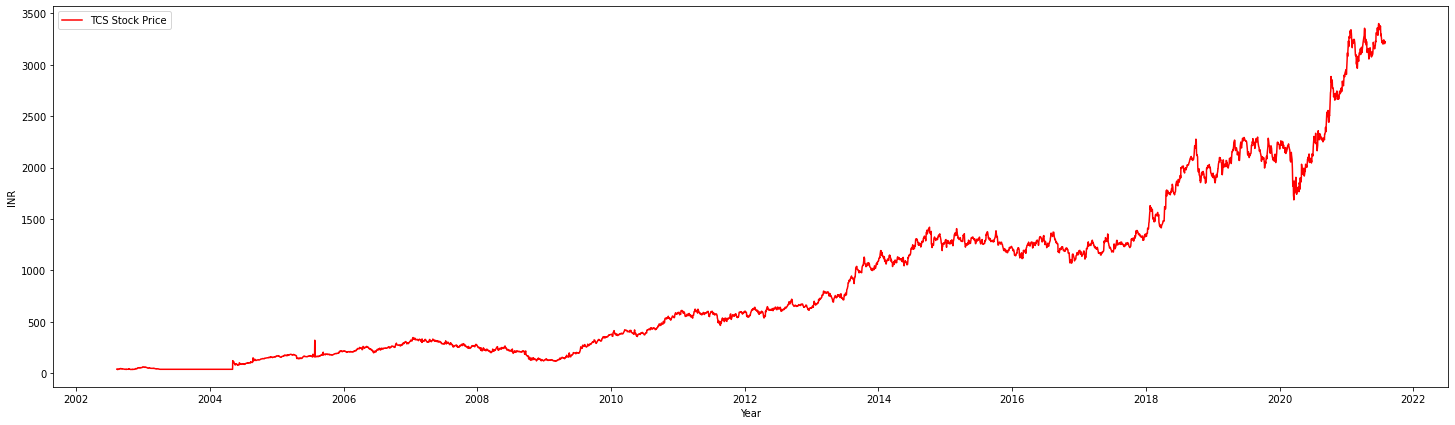

In [7]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date,data.High, color = 'red', label = 'TCS Stock Price')
plt.xlabel('Year')
plt.ylabel('INR')
plt.legend()
plt.show()

# Splitting data into training and testing

In [8]:
data.shape

#rows*colums

(4706, 7)

In [9]:
4706*0.8

3764.8

In [17]:
# 80% will be used for traning, and 20% for testing

train_size = 0.8        # 80%
split_index = int(train_size * data.shape[0])

factors_column = ['Open', 'High', 'Low', 'Close', 'Volume']
y_col_index = 3 # Close

train_set = data[factors_column].values[:split_index]
test_set = data[factors_column].values[split_index:]

In [18]:
split_index

3764

# Scaling data between 0-1
for better learning

In [19]:
from sklearn.preprocessing import MinMaxScaler

# scale our price from 0 to 1

sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

In [20]:
train_set_scaled[0]

array([0.00459044, 0.00256614, 0.00467806, 0.00312379, 0.00405498])

# Generate windowed timestamp data

In [21]:
# this function will combine data of 60 days (we can change it using time_window parameter) 

def generate_data(series, y_col_index, time_window=60):
  X = []
  y = []
  for i in range(60, len(series)):
    X.append(series[i-time_window: i])
    y.append(series[i, y_col_index])
  return (np.array(X), np.array(y))

In [22]:
X_train, y_train = generate_data(train_set_scaled, y_col_index=y_col_index)
X_test, y_test = generate_data(test_set_scaled, y_col_index=y_col_index)

In [23]:
print('Training data shape: ',X_train.shape)
print('We will observe {} days price to predict next day price'.format(X_train.shape[1]))

Training data shape:  (3704, 60, 5)
We will observe 60 days price to predict next day price


# Create Multi Layer LSTM Network

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [25]:
model = Sequential()

# layer 1
#return_sequence=True, it will return something with shape
#unit means the dimension of the inner cells in LSTM.

model.add(LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 5))
model.add(Dropout(0.2))

# layer 5
model.add(Dense(units = 1))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 30)            9720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 10)            1640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 3

## Compile and train LSTM Network

In [28]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train,
          y_train,
          epochs = 50,
          batch_size = 64,
          validation_data = (X_test, y_test))

Epoch 1/50
58/58 [==============================] - 15s 144ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 2/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 3/50
58/58 [==============================] - 7s 118ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 4/50
58/58 [==============================] - 7s 119ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 5/50
58/58 [==============================] - 7s 119ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 6/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 7/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 8/50
58/58 [==============================] - 7s 121ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 9/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 10/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0062 - val_loss: 0.003

# Test trained LSTM Network

In [29]:
test_prediction = model.predict(X_test)
test_prediction = (test_prediction * sc.data_range_[y_col_index]) + sc.data_min_[y_col_index]

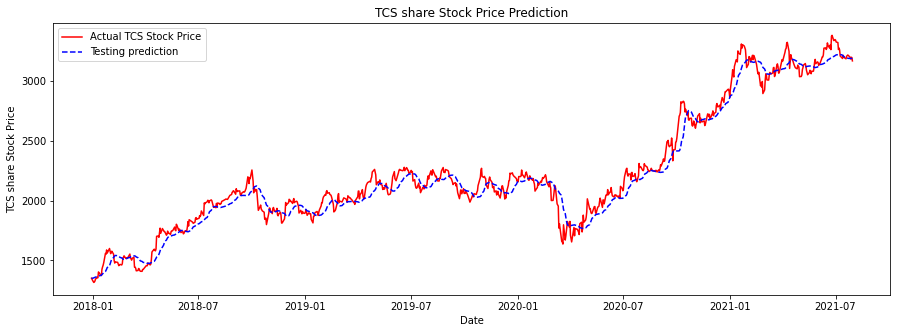

In [30]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+60 : ], data.Close.values[ split_index+60: ], 'r-', label = 'Actual TCS Stock Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Testing prediction')

plt.title('TCS share Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TCS share Stock Price')
plt.legend()
plt.show()

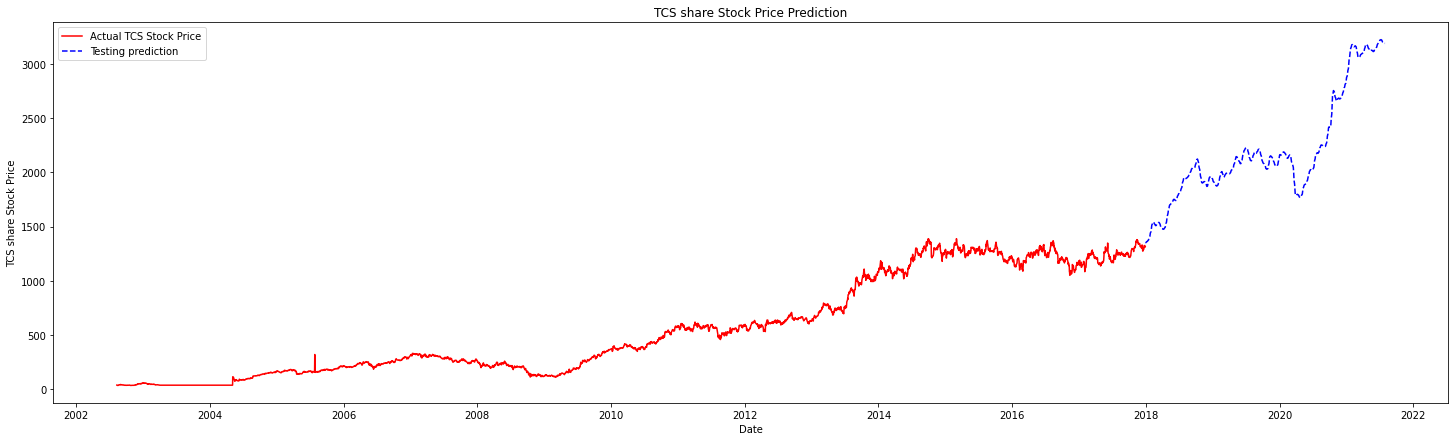

In [31]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date.values[ : split_index+60 ], data.Close.values[ : split_index+60 ], 'r-', label = 'Actual TCS Stock Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Testing prediction')

plt.title('TCS share Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TCS share Stock Price')
plt.legend()
plt.show()

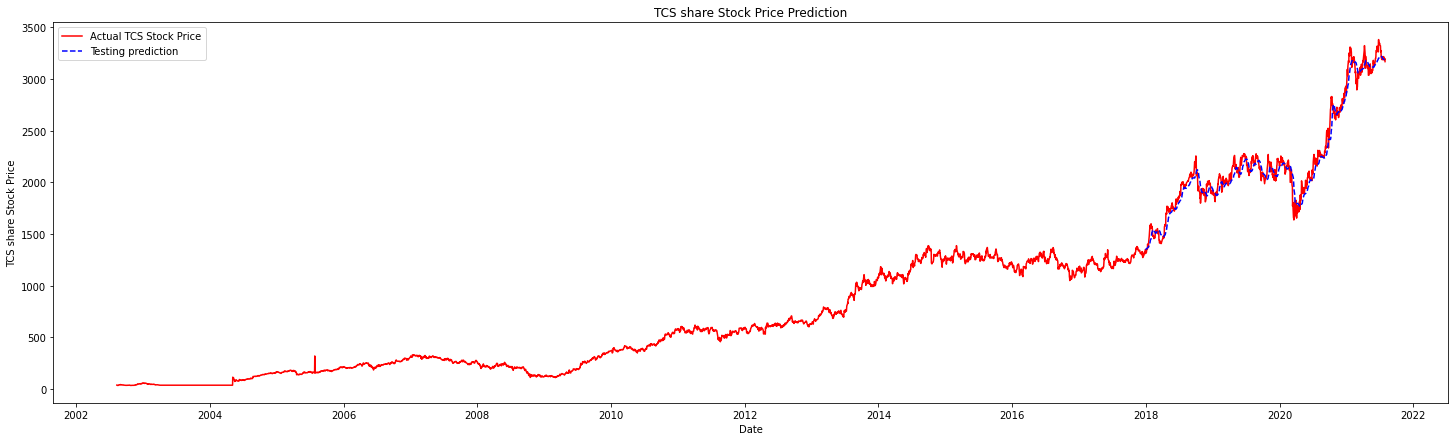

In [32]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'Actual TCS Stock Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Testing prediction')

plt.title('TCS share Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TCS share Stock Price')
plt.legend()
plt.show()

In [33]:
Notebook - https://drive.google.com/file/d/1TKWOtNbmEKptstHlaJriBae6Plc5N90Z/view?usp=sharing
Feedback Link: https://www.techlearn.live/feedback?scheduleId=6133238c40dc202b276ca0bf
Code Link : https://colab.research.google.com/drive/1h0THTUyg_lzAtO36E1XigK2LZUa7-IHO?usp=sharing

SyntaxError: ignored